### Get data 

In [3]:
!wget -c https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv 

--2024-10-06 21:17:17--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv’

laptops.csv         100%[===================>] 291.58K  --.-KB/s    in 0.05s   

2024-10-06 21:17:17 (6.07 MB/s) - ‘laptops.csv’ saved [298573/298573]



In [1]:
import pandas as pd 
import numpy as np 


from plotnine import *
from mizani import *

In [2]:
laptop_df = pd.read_csv('../../data/02-week/laptops.csv')

In [3]:
laptop_df.columns = laptop_df.columns.str.lower().str.replace(' ', '_')

In [4]:
laptop_df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [5]:

string_columns = list(laptop_df.dtypes[laptop_df.dtypes == 'object'].index)

for col in string_columns:
    laptop_df[col] = laptop_df[col].str.lower().str.replace(' ', '_')

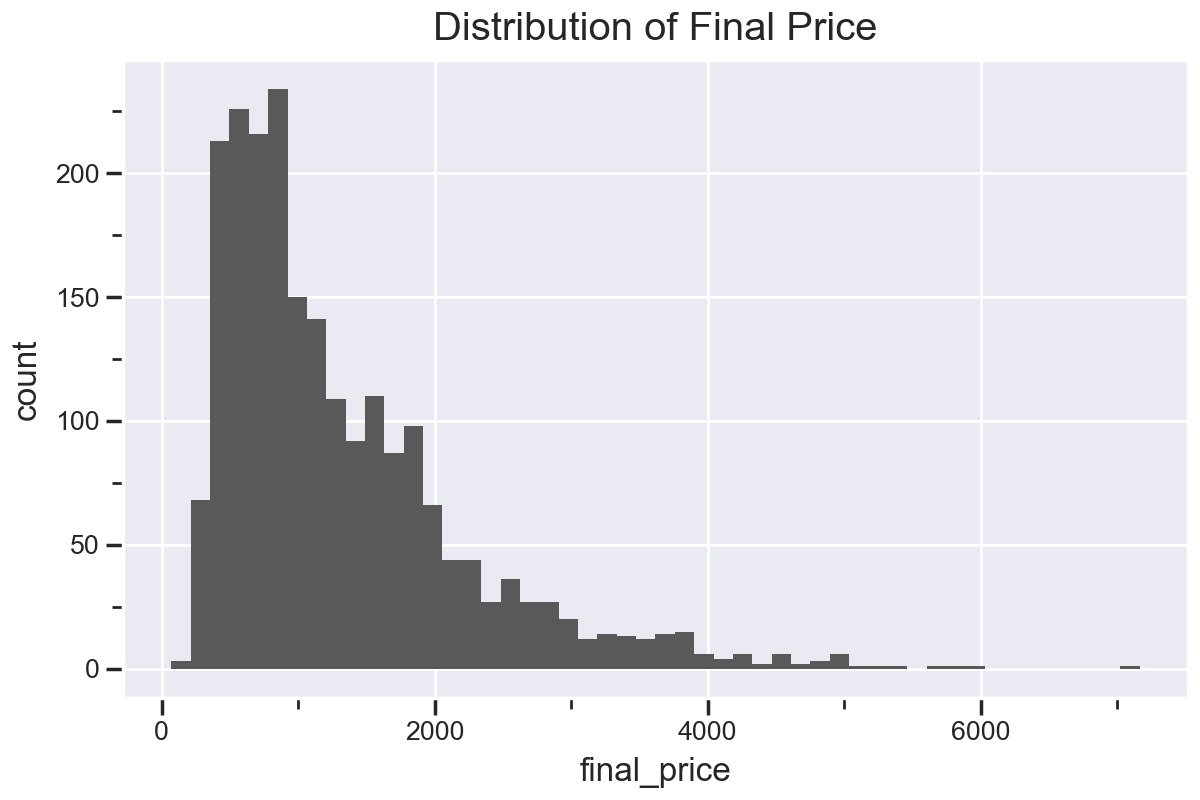

In [6]:
(
        ggplot(laptop_df,aes(x = 'final_price')) 
    + geom_histogram(bins = 50)
    + labs(
        title = 'Distribution of Final Price',
)
 + theme_seaborn()
 + theme(figure_size=(6,4))
)

In [7]:
laptop_df.isnull().sum()

laptop             0
status             0
brand              0
model              0
cpu                0
ram                0
storage            0
storage_type      42
gpu             1371
screen             4
touch              0
final_price        0
dtype: int64

In [8]:
laptop_df['ram'].describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

In [71]:
np.random.seed(42)

n = len(laptop_df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [72]:
idx = np.arange(n)
np.random.shuffle(idx)

In [73]:
laptop_df_shuffled = laptop_df.iloc[idx]

df_train = laptop_df_shuffled.iloc[:n_train].copy()
df_val = laptop_df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = laptop_df_shuffled.iloc[n_train+n_val:].copy()
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1296, 12)
(432, 12)
(432, 12)


In [86]:
y_train =  df_train.final_price.values
y_test =  df_test.final_price.values
y_val = df_val.final_price.values



### Missing = 0 

In [87]:
base = ['ram','storage','screen']
categories = ['cpu','brand','model','gpu']


In [88]:
categories_dict = dict()

for c_val in categories: 
    categories_dict[c_val] = list(laptop_df[c_val].value_counts().head().index)

In [89]:
categories_dict

{'cpu': ['intel_core_i7',
  'intel_core_i5',
  'amd_ryzen_7',
  'intel_core_i3',
  'amd_ryzen_5'],
 'brand': ['asus', 'hp', 'lenovo', 'msi', 'acer'],
 'model': ['15s', 'ideapad', 'rog', 'thinkpad', 'vivobook'],
 'gpu': ['rtx_3050', 'rtx_3060', 'rtx_3070', 'rtx_4060', 'rtx_3080']}

In [90]:
def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0],w_full[1:]

In [91]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [134]:


def prepare_x(df: pd.DataFrame,mean_val=0) -> np.array:
    df = df.copy()  ## Will not modify the original dataframe
    
    
    df_num = df[base]
    df_num.loc[:,'screen'] = df_num.loc[:,'screen'].fillna(mean_val)
    df_num = df_num.fillna(0)
    X = df_num.values
    return X



In [116]:
X_train = prepare_x(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [117]:
X_val = prepare_x(df_val)

In [118]:
y_pred = w_0 + X_val.dot(w)

In [119]:
np.round(rmse(y_pred, y_val),2)

576.1

### Missing == mean 

In [120]:
mean_val = df_train['screen'].mean()

In [121]:
mean_val

15.183667953667953

In [122]:
X_train = prepare_x(df_train,mean_val)
w_0, w = train_linear_regression(X_train, y_train)
X_val = prepare_x(df_val,mean_val)
y_pred = w_0 + X_val.dot(w)
np.round(rmse(y_pred, y_val),2)

575.75

### Regularisation 

In [123]:
def train_linear_regression_reg(X, y,r = 0.01):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [124]:
rmse_values = dict()
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
   X_train = prepare_x(df_train)
   w_0, w = train_linear_regression_reg(X_train, y_train,r=r)
   X_val = prepare_x(df_val)
   y_pred = w_0 + X_val.dot(w)
   print(f'{r}:{rmse(y_pred, y_val)}') 
   rmse_values[r] = rmse(y_pred, y_val)

0:576.1017929433108
0.01:576.1034660483248
0.1:576.1188886594517
1:576.2998734445936
5:577.2151017625024
10:578.1000984906453
100:580.8884191743315


In [125]:
min(rmse_values.values())

576.1017929433108

### Trying the seed 

In [126]:


def prepare_data(seed_Value) :
    np.random.seed(seed_Value)
    n = len(laptop_df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    idx = np.arange(n)
    np.random.shuffle(idx)
    laptop_df_shuffled = laptop_df.iloc[idx]

    df_train = laptop_df_shuffled.iloc[:n_train].copy()
    df_val = laptop_df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = laptop_df_shuffled.iloc[n_train+n_val:].copy()
    y_train =  df_train.final_price.values
    y_test =  df_test.final_price.values
    y_val = df_val.final_price.values
    return df_train,df_val,df_test,y_train,y_val,y_test

In [127]:
rmse_values=list()
for seed_value in range(10):
    print(seed_value)
    df_train,df_val,df_test,y_train,y_val,y_test = prepare_data(seed_value)
    X_train = prepare_x(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_x(df_val)
    y_pred = w_0 + X_val.dot(w)
    rmse_values.append(rmse(y_pred, y_val))

0
1
2
3
4
5
6
7
8
9


In [136]:
np.round(np.std(rmse_values),3)

29.176

In [135]:
df_train,df_val,df_test,y_train,y_val,y_test = prepare_data(9)
df_full_train = pd.concat([df_train,df_val],ignore_index=True)
y_full_train = np.concatenate([y_train,y_val])

X_train = prepare_x(df_full_train)
w_0, w = train_linear_regression_reg(X_train, y_full_train,r=0.001)
X_test = prepare_x(df_test)
y_pred = w_0 + X_test.dot(w)
rmse(y_pred, y_test)

608.609982204956